# Imports

In [291]:
import requests
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import shap  
import tensorflow as tf

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# API

### Key(s)

In [292]:
API_KEY_ALPHAVANTAGE = 'TN1RC72EPA9AEL7Y'

### Request

### Get the stock data

In [293]:
# Can be changed to any stock (e.g., 'MSFT', 'GOOGL')
symbol = 'AAPL'

# Build the url using the stock symbol and api key
url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&outputsize=full&apikey={API_KEY_ALPHAVANTAGE}'

# Request and parse into JSON
response = requests.get(url)
data = response.json()

# Check if the API call was successful
if 'Time Series (Daily)' not in data:
    raise ValueError(f"Error fetching data: {data.get('Information', 'Unknown error')}")

# Dataframe

### Conversion to Dataframe

In [294]:
time_series = data['Time Series (Daily)']
df = pd.DataFrame.from_dict(time_series, orient='index', dtype=float)
df.index = pd.to_datetime(df.index)

# Sort by date (due to stock data being linear, this is of utmost importance)
df = df.sort_index()

# Rename columns due to names being difficult to work with
df = df.rename(columns={
    '1. open': 'open',
    '2. high': 'high',
    '3. low': 'low',
    '4. close': 'close',
    '5. volume': 'volume'
    })

# Show Dataframe
display(df.head())

,open,high,low,close,volume
1999-11-01,80.00,80.69,77.37,77.62,2487300.0
1999-11-02,78.00,81.69,77.31,80.25,3564600.0
1999-11-03,81.62,83.25,81.00,81.50,2932700.0
1999-11-04,82.06,85.37,80.62,83.62,3384700.0
1999-11-05,84.62,88.37,84.00,88.31,3721500.0


# Technical Indicator Computation

### 1 - Moving Averages (SMA10, SMA50)

**SMA10 (10-day):**
$$
\text{sma}_{10}[t] = \frac{1}{10} \sum_{i=t-(10-1)}^{t} \text{close}[i]
$$

**SMA50 (50-day):**
$$
\text{sma}_{50}[t] = \frac{1}{50} \sum_{i=t-(50-1)}^{t} \text{close}[i]
$$

In [295]:
# Calculate the average for 10 and 50 day periods
df['sma10'] = df['close'].rolling(window=10).mean()
df['sma50'] = df['close'].rolling(window=50).mean()

### 2 - Relative Strength Index (RSI) (14-day)

$$
\begin{align}
\Delta[t] &= \text{close}[t] - \text{close}[t-1] \\
\text{gain}_{14}[t] &= \frac{1}{14} \sum_{i=t-(14-1)}^{t} \max(\Delta[i], 0) \\
\text{loss}_{14}[t] &= \frac{1}{14} \sum_{i=t-(14-1)}^{t} \max(-\Delta[i], 0) \\
\text{rs}[t] &= \frac{\text{gain}_{14}[t]}{\text{loss}_{14}[t]} \\
\text{rsi}[t] &= 100 - \frac{100}{1 + \text{rs}[t]}
\end{align}
$$

In [296]:
# Difference between consecutive closing prices
delta = df['close'].diff()

# Keep positive changes and replace negative with 0
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()

# Keep negative changes (negate to make +) and replace positive with 0
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()

# Calculate rs
rs = gain / loss

# Calculate RSI
df['rsi'] = 100 - (100 / (1 + rs))

### 3 - Moving Average Convergence Divergence (MACD)

$$
\begin{align}
\text{ema}_{12}[t] &= \frac{2}{12+1} \times \text{close}[t] + \left(1 - \frac{2}{12+1}\right) \times \text{ema}_{12}[t-1] \\
\text{ema}_{26}[t] &= \frac{2}{26+1} \times \text{close}[t] + \left(1 - \frac{2}{26+1}\right) \times \text{ema}_{26}[t-1] \\
\text{macd}[t] &= \text{ema}_{12}[t] - \text{ema}_{26}[t] \\
\text{macd}_{\text{signal}}[t] &= \frac{2}{9+1} \times \text{macd}[t] + \left(1 - \frac{2}{9+1}\right) \times \text{macd}_{\text{signal}}[t-1]
\end{align}
$$

In [297]:
# Calculate Exponential Moving Averages (EMA)
exp1 = df['close'].ewm(span=12, adjust=False).mean()
exp2 = df['close'].ewm(span=26, adjust=False).mean()

# MACD Line is the difference between the 12-day and 26-day EMA
df['macd'] = exp1 - exp2

# MACD Signal Line is the 9-day EMA of the MACD line
df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()

### 4 - Volatility (Daily Range)

$$
\text{volatility}[t] = \text{high}[t] - \text{low}[t]
$$

In [298]:
# Take the difference between the 'high' and 'low' values for every day
df['volatility'] = df['high'] - df['low']

### 5 - Lagged Returns (1-day)

$$
\text{lag1}_{\text{return}}[t] = \frac{\text{close}[t] - \text{close}[t-1]}{\text{close}[t-1]}
$$

In [299]:
# Take the percent change on a daily basis
df['lag1_return'] = df['close'].pct_change()

### 6 & 7 - Bollinger Bands (Upper and Lower, 20-day)

$$
\begin{align}
\text{bb}_{\text{middle}}[t] &= \frac{1}{20} \sum_{i=t-(20-1)}^{t} \text{close}[i] \\
\text{bb}_{\text{std}}[t] &= \sqrt{\frac{1}{20} \sum_{i=t-(20-1)}^{t} \left( \text{close}[i] - \text{bb}_{\text{middle}}[t] \right)^2} \\
\text{bb}_{\text{upper}}[t] &= \text{bb}_{\text{middle}}[t] + 2 \times \text{bb}_{\text{std}}[t] \\
\text{bb}_{\text{lower}}[t] &= \text{bb}_{\text{middle}}[t] - 2 \times \text{bb}_{\text{std}}[t]
\end{align}
$$

In [300]:
# Calculate the middle band (SMA for 20-day period)
df['bb_middle'] = df['close'].rolling(window=20).mean()

# Calculate the Standard Deviation
df['bb_std'] = df['close'].rolling(window=20).std()

# Calculate the Upper and Lower Bands using the Middle and the Standard Deviation
df['bb_upper'] = df['bb_middle'] + 2 * df['bb_std']
df['bb_lower'] = df['bb_middle'] - 2 * df['bb_std']

### 8 - Stochastic Oscillator (%K, 14-day)

$$
\begin{align}
\text{low}_{14}[t] &= \min_{i=t-(14-1)}^{t} (\text{low}[i]) \\
\text{high}_{14}[t] &= \max_{i=t-(14-1)}^{t} (\text{high}[i]) \\
\text{stoch}_{\text{k}}[t] &= 100 \times \frac{\text{close}[t] - \text{low}_{14}[t]}{\text{high}_{14}[t] - \text{low}_{14}[t]}
\end{align}
$$

In [301]:
# Calculate Highest High and Lowest Low for the 14 day period
high_14 = df['high'].rolling(window=14).max()
low_14 = df['low'].rolling(window=14).min()

# Determine the %K value using the formula
df['stoch_k'] = 100 * (df['close'] - low_14) / (high_14 - low_14)

### 9 - Average True Range (ATR, 14-day)

$$
\begin{align}
\text{tr1}[t] &= \text{high}[t] - \text{low}[t] \\
\text{tr2}[t] &= \left| \text{high}[t] - \text{close}[t-1] \right| \\
\text{tr3}[t] &= \left| \text{low}[t] - \text{close}[t-1] \right| \\
\text{tr}[t] &= \max(\text{tr1}[t], \text{tr2}[t], \text{tr3}[t]) \\
\text{atr}[t] &= \frac{1}{14} \sum_{i=t-(14-1)}^{t} \text{tr}[i]
\end{align}
$$

In [302]:
# Calculate tr1, the high - low of a stock for a given day
df['tr1'] = df['high'] - df['low']

# Calculate tr2, the absolute value of the 'high' - 'close' of the previous day
df['tr2'] = abs(df['high'] - df['close'].shift())

# Calculate tr3, the absolute value of the 'lwo' - 'close' of the previous day
df['tr3'] = abs(df['low'] - df['close'].shift())

# Calculate tr, the largest price movement for the day
df['tr'] = df[['tr1', 'tr2', 'tr3']].max(axis=1)

# Calculate the ATR for on  a day (t)
df['atr'] = df['tr'].rolling(window=14).mean()

### 10 - On-Balance Volume (OBV)

$$
\begin{align}
\text{close}_{\text{diff}}[t] &= \text{close}[t] - \text{close}[t-1] \\
\text{direction}[t] &= \text{sign}(\text{close}_{\text{diff}}[t]) \\
\text{volume}_{\text{adj}}[t] &= \text{direction}[t] \times \text{volume}[t] \\
\text{obv}[t] &= \sum_{i=1}^{t} \text{volume}_{\text{adj}}[i]
\end{align}
$$

In [303]:
# Calculate obv buy taking the sign of the difference of the close price - prev. close price
# Then multiply it by the volume of the day, and finally summing it all together cumulatively.
df['obv'] = (np.sign(df['close'].diff()) * df['volume']).cumsum()

# Fill NA Values with 0 due to the first value (close[i - 1]) not existing
df['obv'] = df['obv'].fillna(0)

# Data Cleaning

### Dropping of Temporary Columns

In [304]:
# Drop the temporary columns
df = df.drop(columns=['bb_middle', 'bb_std', 'tr1', 'tr2', 'tr3', 'tr'])

### Inspecting N/A Values

In [305]:
display(df.head())

,open,high,low,close,volume,sma10,sma50,rsi,macd,macd_signal,volatility,lag1_return,bb_upper,bb_lower,stoch_k,atr,obv
1999-11-01,80.00,80.69,77.37,77.62,2487300.0,NaN,NaN,NaN,0.000000,0.000000,3.32,NaN,NaN,NaN,NaN,NaN,0.0
1999-11-02,78.00,81.69,77.31,80.25,3564600.0,NaN,NaN,NaN,0.209801,0.041960,4.38,0.033883,NaN,NaN,NaN,NaN,3564600.0
1999-11-03,81.62,83.25,81.00,81.50,2932700.0,NaN,NaN,NaN,0.471498,0.127868,2.25,0.015576,NaN,NaN,NaN,NaN,6497300.0
1999-11-04,82.06,85.37,80.62,83.62,3384700.0,NaN,NaN,NaN,0.840276,0.270349,4.75,0.026012,NaN,NaN,NaN,NaN,9882000.0
1999-11-05,84.62,88.37,84.00,88.31,3721500.0,NaN,NaN,NaN,1.493760,0.515031,4.37,0.056087,NaN,NaN,NaN,NaN,13603500.0


In [306]:
display(df.tail())

,open,high,low,close,volume,sma10,sma50,rsi,macd,macd_signal,volatility,lag1_return,bb_upper,bb_lower,stoch_k,atr,obv
2025-04-14,211.440,212.9400,201.1621,202.52,101352911.0,198.247,223.8198,40.762336,-8.994919,-8.347422,11.7779,0.022054,240.197794,177.068206,59.049741,13.248200,4.039312e+09
2025-04-15,201.855,203.5100,199.8000,202.14,51343872.0,196.142,223.3024,41.425666,-8.219256,-8.321788,3.7100,-0.001876,239.737368,176.473632,58.376101,13.188200,3.987968e+09
2025-04-16,198.360,200.7000,192.3700,194.27,59732423.0,193.180,222.5318,37.531614,-8.145682,-8.286567,8.3300,-0.038933,239.080888,175.033112,44.424649,13.569636,3.928236e+09
2025-04-17,197.200,198.8335,194.4200,196.98,52164675.0,192.559,221.8220,40.934304,-7.779028,-8.185059,4.4135,0.013950,238.347219,174.054781,49.228770,13.454886,3.980401e+09
2025-04-21,193.265,193.8000,189.8112,193.16,46742537.0,193.037,221.0208,37.401061,-7.707843,-8.089616,3.9888,-0.019393,237.068400,172.822600,42.783035,13.296229,3.933658e+09


In [307]:
# Count NaN values in each column
nan_counts = df.isna().sum()
print("Number of NaN values in each column before dropping rows:")
print(nan_counts)

# Total number of rows with at least one NaN
rows_with_nan = df.isna().any(axis=1).sum()
print(f"\nTotal number of rows with at least one NaN value: {rows_with_nan}")

Number of NaN values in each column before dropping rows:
open            0
high            0
low             0
close           0
volume          0
sma10           9
sma50          49
rsi            13
macd            0
macd_signal     0
volatility      0
lag1_return     1
bb_upper       19
bb_lower       19
stoch_k        13
atr            13
obv             0
dtype: int64

Total number of rows with at least one NaN value: 49


In [308]:
# Dropping of NA values
print(df.shape)
df = df.dropna()
print(df.shape)

(6406, 17)
(6357, 17)


In [309]:
# Doing another count to confirm all NA values are dropped
# Count NaN values in each column
nan_counts = df.isna().sum()
print("Number of NaN values in each column before dropping rows:")
print(nan_counts)

# Total number of rows with at least one NaN
rows_with_nan = df.isna().any(axis=1).sum()
print(f"\nTotal number of rows with at least one NaN value: {rows_with_nan}")

Number of NaN values in each column before dropping rows:
open           0
high           0
low            0
close          0
volume         0
sma10          0
sma50          0
rsi            0
macd           0
macd_signal    0
volatility     0
lag1_return    0
bb_upper       0
bb_lower       0
stoch_k        0
atr            0
obv            0
dtype: int64

Total number of rows with at least one NaN value: 0


# Machine Learning

### Data Preparation

In [310]:
# Define features and target
features = ['open', 'high', 'low', 'close', 'volume', 'sma10', 'sma50', 'rsi', 'macd', 'macd_signal', 
            'volatility', 'lag1_return', 'bb_upper', 'bb_lower', 'stoch_k', 'atr', 'obv']
target = 'close'

# Normalize features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Scale features
X_data = df[features].values
X_scaled = scaler_X.fit_transform(X_data)

# Scale target
y_data = df[target].values
y_scaled = scaler_y.fit_transform(y_data.reshape(-1, 1))

# Create sequences (use 30 days to predict the next day's closing price)
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i + seq_length])  # Past 30 days of features
        y_seq.append(y[i + seq_length])    # Next day's close
    return np.array(X_seq), np.array(y_seq)

seq_length = 30
X, y = create_sequences(X_scaled, y_scaled, seq_length)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"\nTraining data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")


Training data shape: (5061, 30, 17)
Testing data shape: (1266, 30, 17)


### Model Building

In [311]:
model = Sequential([
    # First Bidirectional LSTM layer
    Bidirectional(LSTM(units=100, return_sequences=True, input_shape=(seq_length, len(features)))),
    Dropout(0.3),
    
    # Second Bidirectional LSTM layer
    Bidirectional(LSTM(units=100, return_sequences=True)),
    Dropout(0.3),
    
    # Third Bidirectional LSTM layer
    Bidirectional(LSTM(units=50, return_sequences=False)),
    Dropout(0.3),
    
    # Dense layers with regularization and batch normalization
    Dense(units=50, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(units=25, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dense(units=1)  # Output: predicted close price (scaled)
])

c:\Users\Adolf\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Model Training and Predictions

In [312]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Display model summary
model.summary()

# Train the Model
history = model.fit(
    X_train, y_train,
    epochs=18,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_42                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_43                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_44                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/18
159/159 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 1.8000 - val_loss: 0.8560
Epoch 2/18
159/159 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.9470 - val_loss: 0.7076
Epoch 3/18
159/159 ━━━━━━━━━━━━━━━━━━━━ 17s 83ms/step - loss: 0.6929 - val_loss: 0.5444
Epoch 4/18
159/159 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - loss: 0.5291 - val_loss: 0.4150
Epoch 5/18
159/159 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - loss: 0.4002 - val_loss: 0.3128
Epoch 6/18
159/159 ━━━━━━━━━━━━━━━━━━━━ 22s 85ms/step - loss: 0.3002 - val_loss: 0.2333
Epoch 7/18
159/159 ━━━━━━━━━━━━━━━━━━━━ 19s 74ms/step - loss: 0.2219 - val_loss: 0.1702
Epoch 8/18
159/159 ━━━━━━━━━━━━━━━━━━━━ 22s 81ms/step - loss: 0.1632 - val_loss: 0.1227
Epoch 9/18
159/159 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - loss: 0.1182 - val_loss: 0.0896
Epoch 10/18
159/159 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/step - loss: 0.0845 - val_loss: 0.0626
Epoch 11/18
159/159 ━━━━━━━━━━━━━━━━━━━━ 22s 82ms/step - loss: 0.0617 - val_loss: 0.0429
Epoch 12/18
159/159 ━━━━━━━━━━━━

# Data Visualization

### Predicting and transforming

In [313]:
# Predict on training and testing sets
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions to original scale
train_predict_actual = scaler_y.inverse_transform(train_predict)
y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1))
test_predict_actual = scaler_y.inverse_transform(test_predict)
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))

159/159 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


### RMSE and Loss Curve


Train RMSE: 46.43
Test RMSE: 42.44


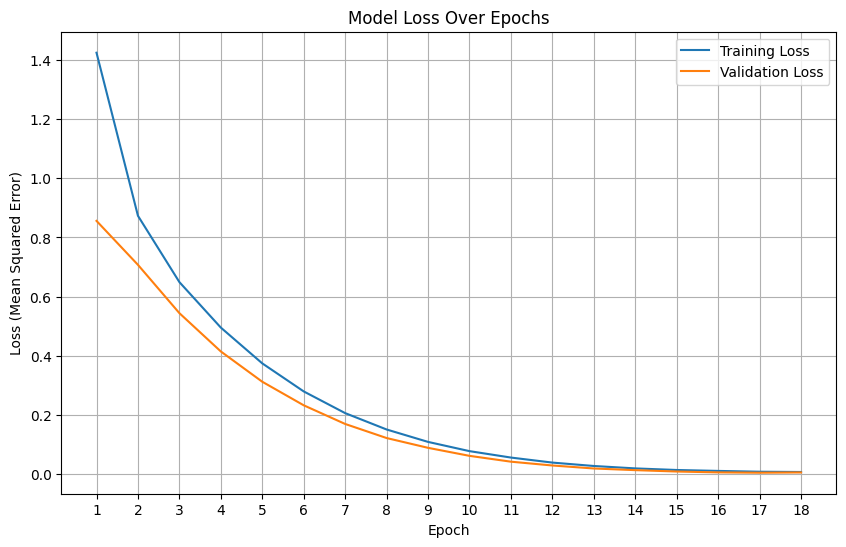

In [314]:
# Calculate RMSE for evaluation
train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_predict_actual))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predict_actual))
print(f"\nTrain RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")

# Plot training and validation loss with integer ticks on x-axis
plt.figure(figsize=(10, 6))
plt.plot(range(1, 19), history.history['loss'], label='Training Loss')
plt.plot(range(1, 19), history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (Mean Squared Error)')
plt.xticks(range(1, 19, 1))  # Integer ticks: 1, 2, ..., 18
plt.legend()
plt.grid(True)
plt.show()

### Graph Predicted Values vs. Actual Values

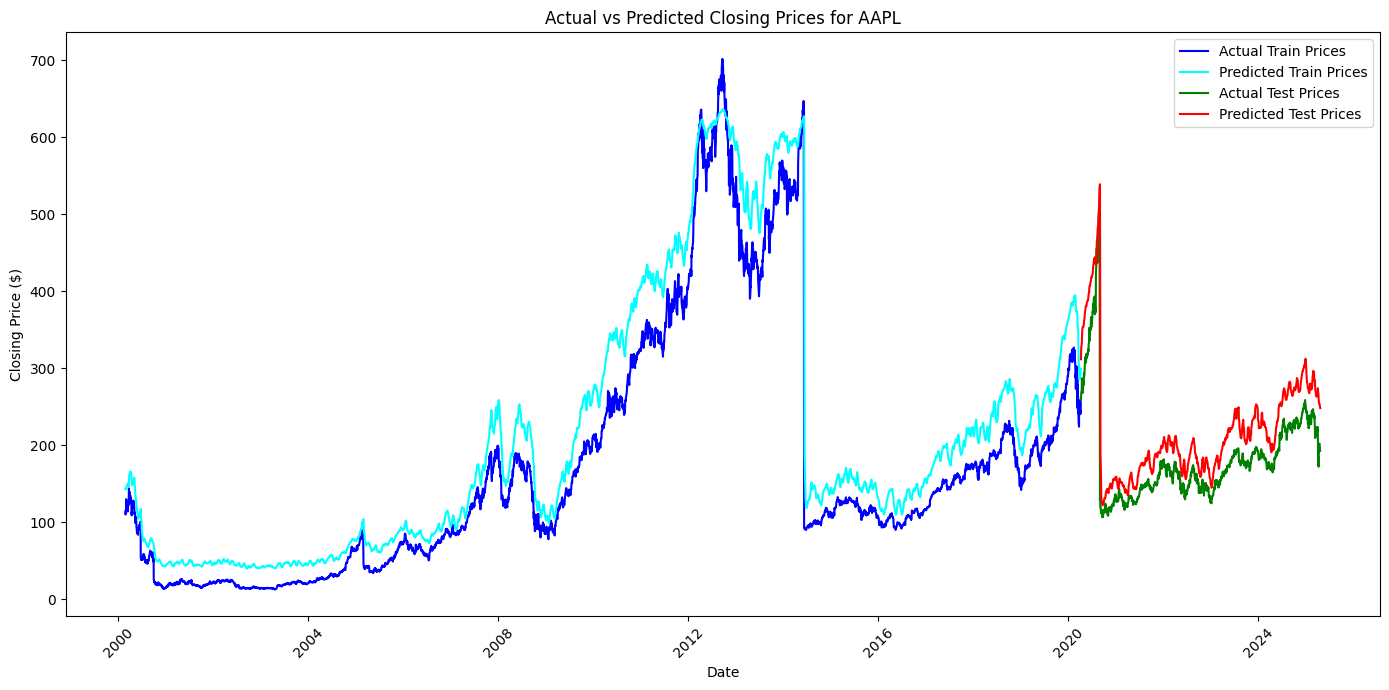

In [315]:
# Plot actual vs predicted prices
# Adjust indices to account for sequence length
train_dates = df.index[seq_length:len(train_predict_actual) + seq_length]
test_dates = df.index[len(train_predict_actual) + seq_length:len(train_predict_actual) + seq_length + len(test_predict_actual)]

plt.figure(figsize=(14, 7))
plt.plot(train_dates, y_train_actual, label='Actual Train Prices', color='blue')
plt.plot(train_dates, train_predict_actual, label='Predicted Train Prices', color='cyan')
plt.plot(test_dates, y_test_actual, label='Actual Test Prices', color='green')
plt.plot(test_dates, test_predict_actual, label='Predicted Test Prices', color='red')
plt.title(f'Actual vs Predicted Closing Prices for {symbol}')
plt.xlabel('Date')
plt.ylabel('Closing Price ($)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Plot the Residuals

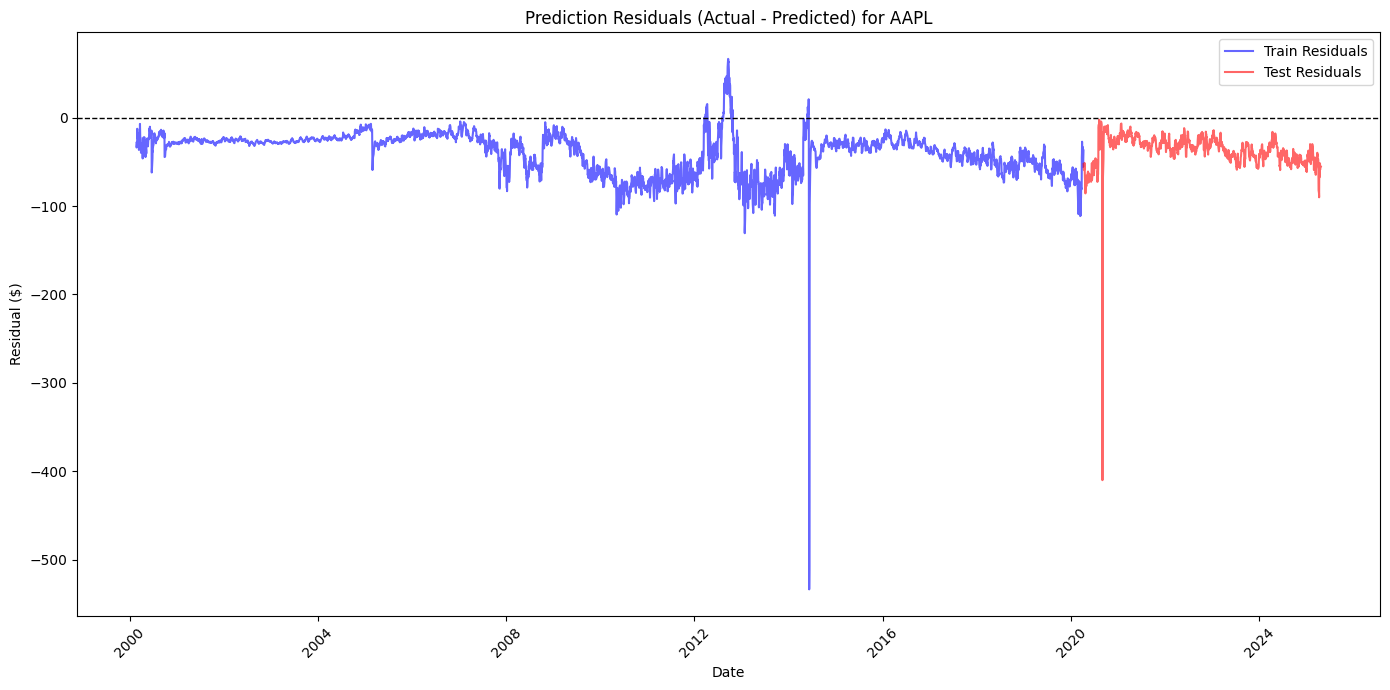

In [316]:
# Plot residuals (prediction errors) over time
# Calculate residuals: actual - predicted
train_residuals = y_train_actual.flatten() - train_predict_actual.flatten()
test_residuals = y_test_actual.flatten() - test_predict_actual.flatten()

plt.figure(figsize=(14, 7))
plt.plot(train_dates, train_residuals, label='Train Residuals', color='blue', alpha=0.6)
plt.plot(test_dates, test_residuals, label='Test Residuals', color='red', alpha=0.6)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Zero line for reference
plt.title(f'Prediction Residuals (Actual - Predicted) for {symbol}')
plt.xlabel('Date')
plt.ylabel('Residual ($)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Predict for the Next Day

In [317]:
# Block 7: Predict the Stock Price for the Next Day
# Use the most recent sequence to predict the next day
last_sequence = X_scaled[-seq_length:].copy()  # Shape: (seq_length, n_features)

# Reshape the sequence for prediction
current_sequence = last_sequence.reshape(1, seq_length, len(features))

# Predict the next day's closing price (scaled)
next_pred = model.predict(current_sequence)
next_pred_price = next_pred[0][0]  # Predicted close (still scaled)

# Inverse transform to get the actual price
predicted_price = scaler_y.inverse_transform([[next_pred_price]])[0][0]

# Print the final prediction
print(f"\nPredicted closing price for {symbol} on April 14, 2025: ${predicted_price:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step

Predicted closing price for AAPL on April 14, 2025: $241.82


### Backtesting


Backtesting Results (2021-01-01 to Present):
Initial Capital: $1000.00
Final Portfolio Value: $1476.31
Total Return: 47.63%


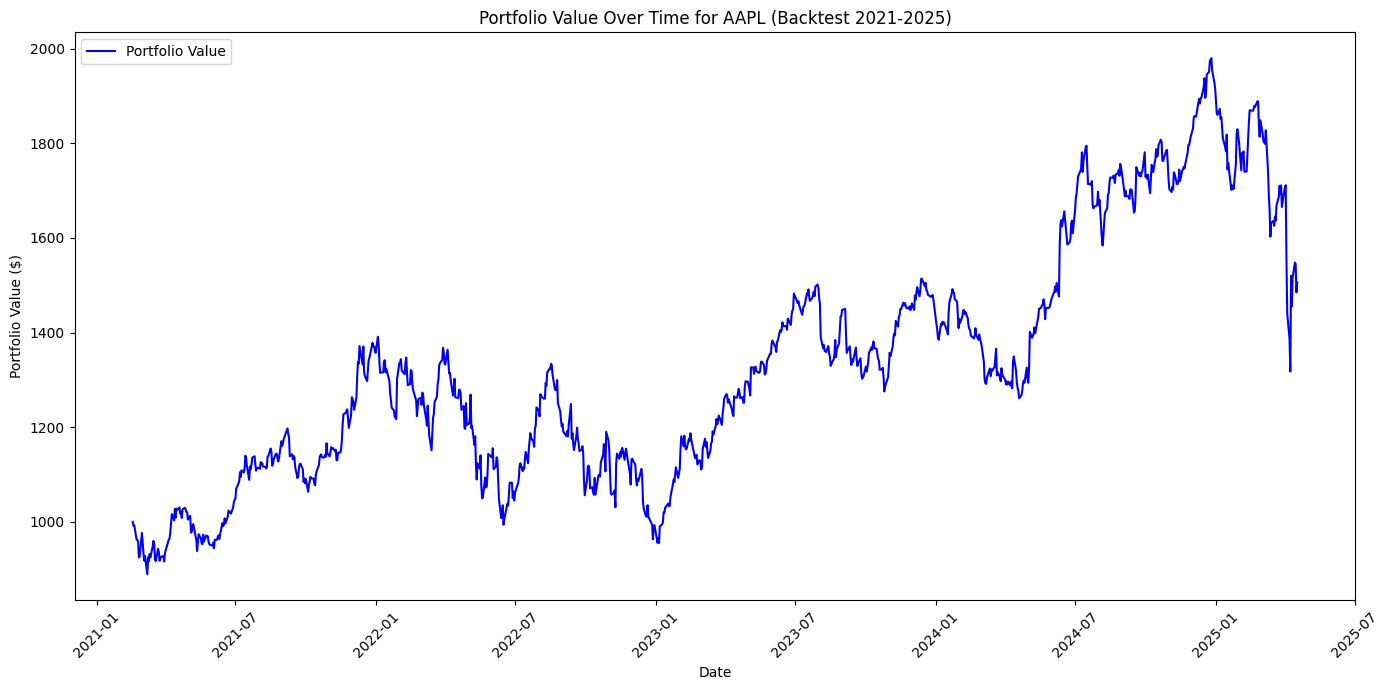

In [318]:
# Define backtesting period
start_date = pd.to_datetime('2021-01-01')
end_date = pd.to_datetime('2025-04-21')

# Filter historical data for the backtesting period
df_backtest = df[(df.index >= start_date) & (df.index <= end_date)].copy()

# Initialize portfolio
initial_capital = 1000.0
cash = initial_capital
shares = 0.0
portfolio_values = []

# Features for the model (same as used in training)
features = ['open', 'high', 'low', 'close', 'volume', 'sma10', 'sma50', 'rsi', 'macd', 'macd_signal', 
            'volatility', 'lag1_return', 'bb_upper', 'bb_lower', 'stoch_k', 'atr', 'obv']

# Ensure scaler_X is the same as used in training (fitted on the full dataset)
# Scale the backtesting data
X_backtest = df_backtest[features].values
X_backtest_scaled = scaler_X.transform(X_backtest)

# Generate sequences for predictions
seq_length = 30
X_sequences = []
dates = []
for i in range(len(X_backtest_scaled) - seq_length):
    X_sequences.append(X_backtest_scaled[i:i + seq_length])
    dates.append(df_backtest.index[i + seq_length])
X_sequences = np.array(X_sequences)

# Generate predictions for each day
predictions = model.predict(X_sequences, verbose=0)
predictions_actual = scaler_y.inverse_transform(predictions)

# Simulate trading
for i in range(len(predictions_actual) - 1):  # -1 because the next day's actual price is needed
    current_date = dates[i]
    current_price = df_backtest.loc[current_date, 'close']
    predicted_next_price = predictions_actual[i][0]
    next_date = dates[i + 1]
    next_actual_price = df_backtest.loc[next_date, 'close']

    # Trading logic
    if predicted_next_price > current_price:
        # Buy: Invest all cash in AAPL
        if cash > 0:
            shares = cash / current_price
            cash = 0.0
    else:
        # Sell: Liquidate all shares
        if shares > 0:
            cash = shares * current_price
            shares = 0.0

    # Calculate portfolio value at the end of the day
    portfolio_value = cash + (shares * current_price)
    portfolio_values.append(portfolio_value)

# Final portfolio value on the last day)
final_date = dates[-1]
final_price = df_backtest.loc[final_date, 'close']
final_portfolio_value = cash + (shares * final_price)

print(f"\nBacktesting Results (2021-01-01 to Present):")
print(f"Initial Capital: ${initial_capital:.2f}")
print(f"Final Portfolio Value: ${final_portfolio_value:.2f}")
print(f"Total Return: {((final_portfolio_value - initial_capital) / initial_capital) * 100:.2f}%")

# Optional: Plot portfolio value over time
plt.figure(figsize=(14, 7))
plt.plot(dates[:-1], portfolio_values, label='Portfolio Value', color='blue')
plt.title(f'Portfolio Value Over Time for {symbol} (Backtest 2021-2025)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()